IndexError: list index out of range

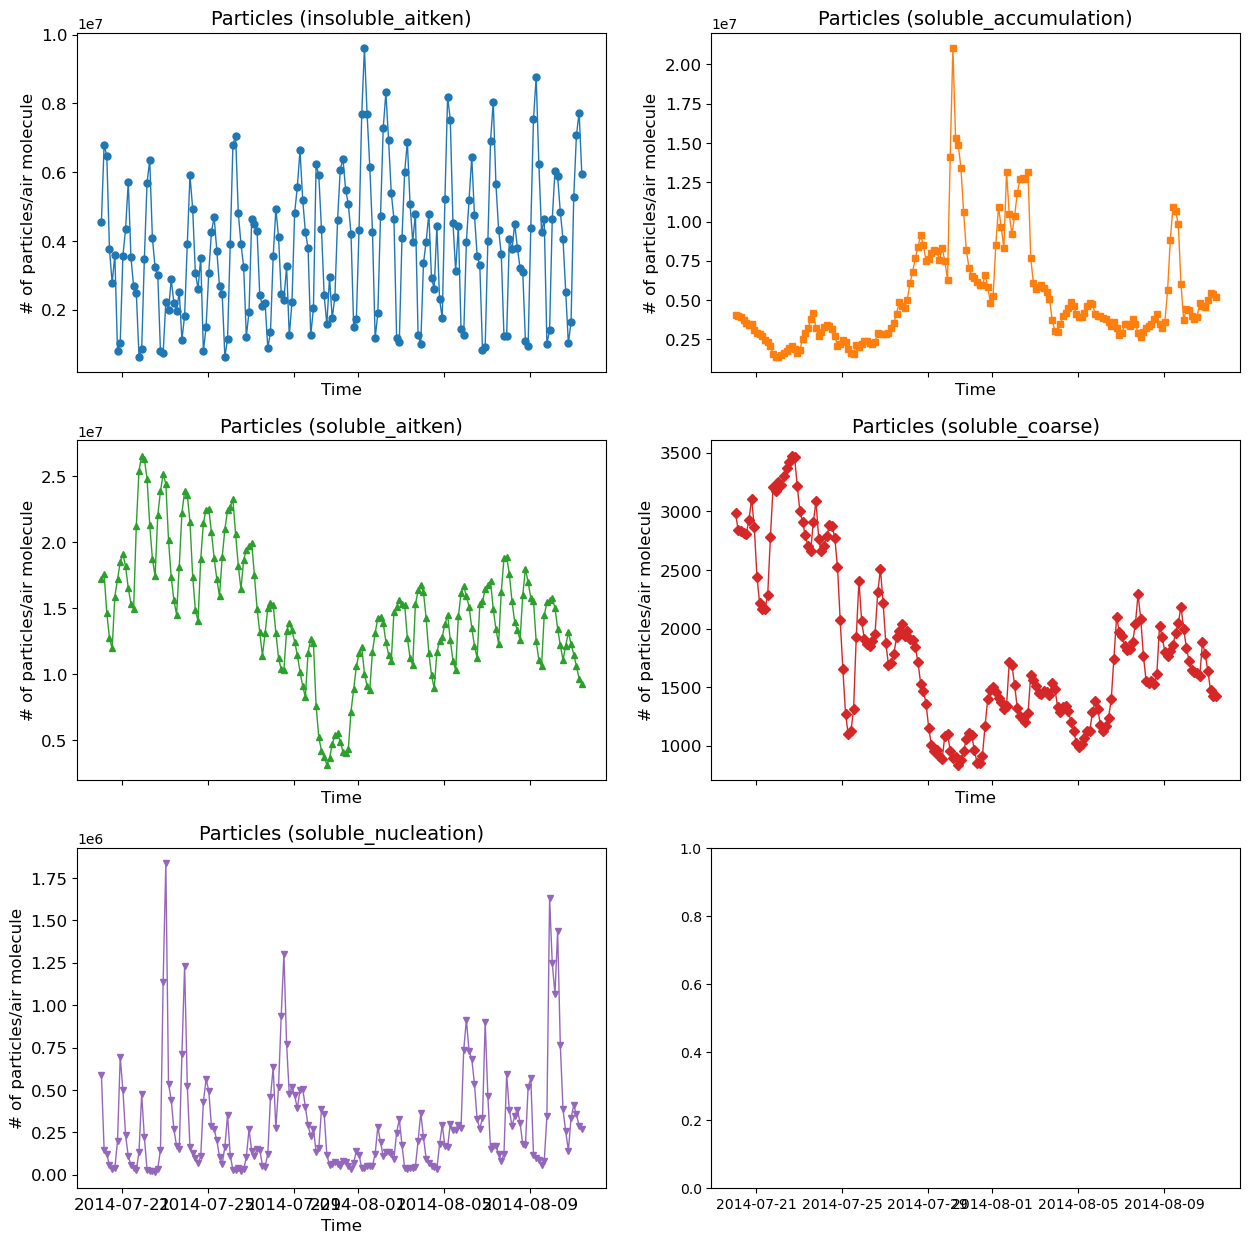

In [ ]:
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import os

def read_pt_data(potential_temperature_file, air_pressure_file):
    chunks = {'time': 20, 'model_level_number': 5, 'grid_latitude': 10, 'grid_longitude': 10}
    
    ds_theta = xr.open_dataset(potential_temperature_file, chunks=chunks)
    ds_p = xr.open_dataset(air_pressure_file, chunks=chunks)

    potential_temperature = ds_theta['air_potential_temperature']
    air_pressure = ds_p['air_pressure']
    
    return potential_temperature, air_pressure

def convert_theta_to_temperature(potential_temperature, air_pressure):
    Rd_cp = 287.05 / 1004.0
    temperature = potential_temperature * (air_pressure / 100000.0) ** Rd_cp
    return temperature
         
def mixing_ratio_to_number_concentration(mixing_ratio_data, air_pressure, actual_temperature):
    R = 287.0
    Na = 6.022e23
    air_density = air_pressure / (R * actual_temperature)
    number_concentration = mixing_ratio_data * air_density * Na
    return number_concentration

def process_nc_file(filename, air_pressure, actual_temperature):
    chunks = {'time': 20, 'model_level_number': 5, 'grid_latitude': 10, 'grid_longitude': 10}
    ds = xr.open_dataset(filename, chunks=chunks)
    variable_name = filename.split('/')[-1].split('_')[1:-1]
    variable_data = ds['_'.join(variable_name)]
    number_concentration_data = mixing_ratio_to_number_concentration(variable_data, air_pressure, actual_temperature)
    number_concentration_mean = number_concentration_data.mean(dim=['grid_latitude', 'grid_longitude']).sel(model_level_number=3)
    time_data = ds['time']
    number_concentration_mean_value = number_concentration_mean.compute()
    time_data_value = time_data.compute()
    return number_concentration_mean_value, time_data_value

def process_nc_files(filenames, air_pressure, actual_temperature):
    number_concentration_mean_values = []
    time_data_values = []
    for filename in filenames:
        number_concentration_mean_value, time_data_value = process_nc_file(filename, air_pressure, actual_temperature)
        number_concentration_mean_values.append(number_concentration_mean_value)
        time_data_values.append(time_data_value)
    return number_concentration_mean_values, time_data_values

# Updated plot_data function
def plot_data(time_data_values, number_concentration_mean_values, filenames):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharex=True)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    markers = ['o', 's', '^', 'D', 'v']
    
    labels = []
    for filename in filenames:
        variable_name = filename.split('/')[-1].split('_')[8:10]
        variable_name = '_'.join(variable_name)
        label = filename.split('/')[-1].split('_')[3].capitalize() + ' (' + variable_name + ')'
        labels.append(label)

    for i, (time_data_value, number_concentration_mean_value) in enumerate(zip(time_data_values, number_concentration_mean_values)):
        row = i // 2
        col = i % 2
        axes[row, col].plot(time_data_value, number_concentration_mean_value, label=labels[i], color=colors[i], marker=markers[i], markersize=5, linewidth=1)
        axes[row, col].set_title(labels[i], fontsize=14)
        axes[row, col].tick_params(axis='both', labelsize=12)
        axes[row, col].set_xlabel('Time', fontsize=12)
        axes[row, col].set_ylabel('# of particles/air molecule', fontsize=12)

    fig.suptitle('Time series of July-August, 2014', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.xticks(rotation=30)
    plt.show()

# Example usage code
path_ct706 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-ct706/full_nc_files/"
path_cs093 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-cs093/full_nc_files/"

filenames = [
    # u-ct706 files
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc',
    # u-cs093 files
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc'
]

potential_temperature_file_ct706 = path_ct706 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_ct706 = path_ct706 + 'Rgn_air_pressure_m01s00i408.nc'

potential_temperature_file_cs093 = path_cs093 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_cs093 = path_cs093 + 'Rgn_air_pressure_m01s00i408.nc'

potential_temperature_ct706, air_pressure_ct706 = read_pt_data(potential_temperature_file_ct706, air_pressure_file_ct706)
actual_temperature_ct706 = convert_theta_to_temperature(potential_temperature_ct706, air_pressure_ct706)

potential_temperature_cs093, air_pressure_cs093 = read_pt_data(potential_temperature_file_cs093, air_pressure_file_cs093)
actual_temperature_cs093 = convert_theta_to_temperature(potential_temperature_cs093, air_pressure_cs093)

number_concentration_mean_values_ct706, time_data_values_ct706 = process_nc_files(filenames[:5], air_pressure_ct706, actual_temperature_ct706)
number_concentration_mean_values_cs093, time_data_values_cs093 = process_nc_files(filenames[5:], air_pressure_cs093, actual_temperature_cs093)

number_concentration_mean_values = number_concentration_mean_values_ct706 + number_concentration_mean_values_cs093
time_data_values = time_data_values_ct706 + time_data_values_cs093

plot_data(time_data_values, number_concentration_mean_values, filenames[:5] + filenames[5:])


In [ ]:
# the next version is to fix the overlapping issue:

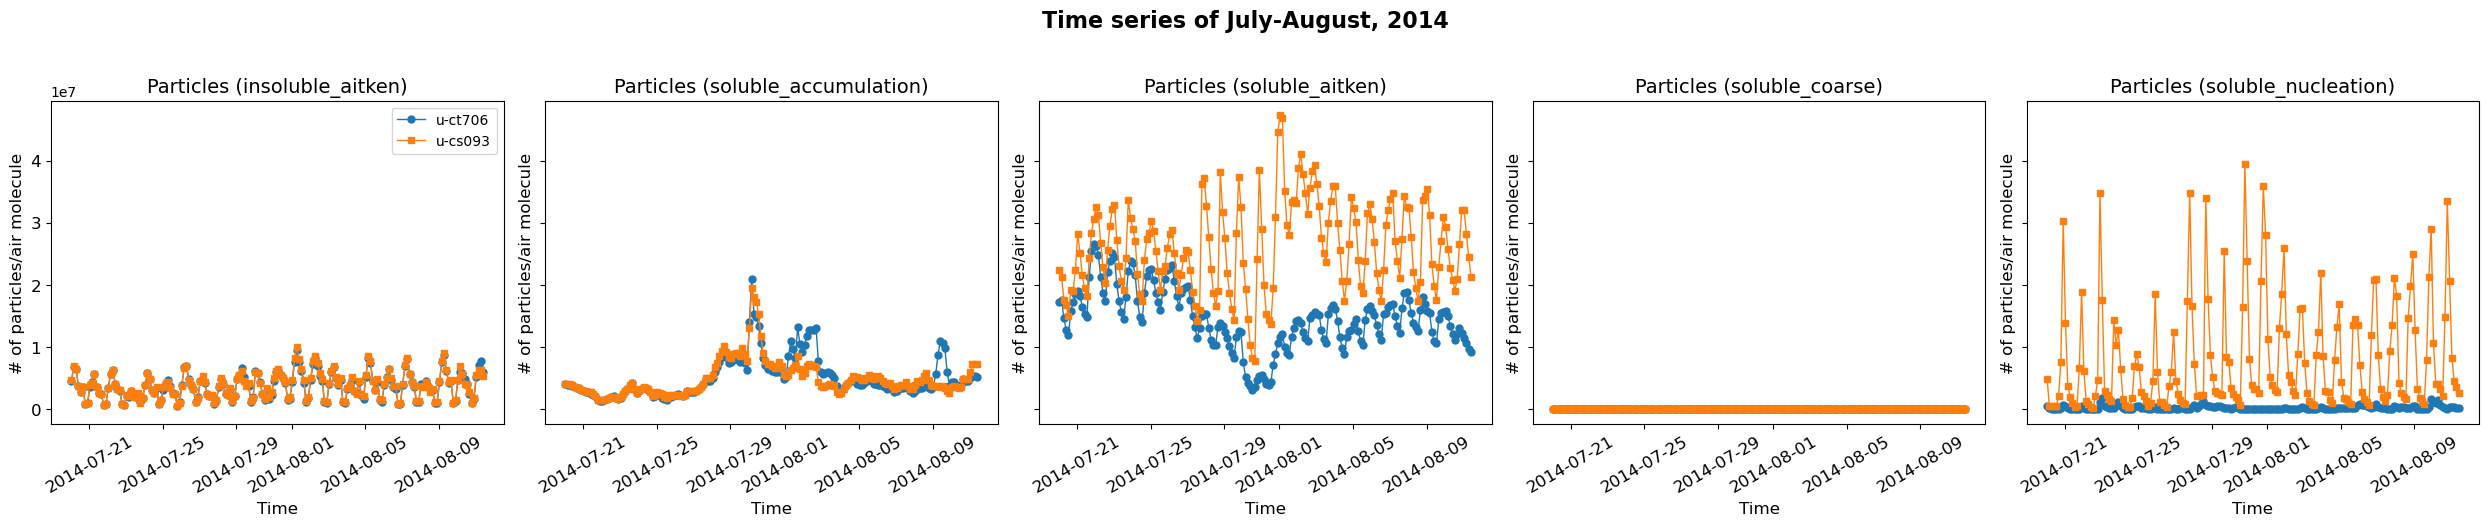

In [ ]:
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import os

def read_pt_data(potential_temperature_file, air_pressure_file):
    chunks = {'time': 20, 'model_level_number': 5, 'grid_latitude': 10, 'grid_longitude': 10}
    
    ds_theta = xr.open_dataset(potential_temperature_file, chunks=chunks)
    ds_p = xr.open_dataset(air_pressure_file, chunks=chunks)

    potential_temperature = ds_theta['air_potential_temperature']
    air_pressure = ds_p['air_pressure']
    
    return potential_temperature, air_pressure

def convert_theta_to_temperature(potential_temperature, air_pressure):
    Rd_cp = 287.05 / 1004.0
    temperature = potential_temperature * (air_pressure / 1000.0) ** Rd_cp  #hpa
    return temperature

def mixing_ratio_to_number_concentration(mixing_ratio_data, air_pressure, actual_temperature):
    R = 287.0
    Na = 6.022e23
    air_density = air_pressure / (R * actual_temperature)
    number_concentration = mixing_ratio_data * air_density * Na
    return number_concentration

#     zboltz=1.3807E-23
#     staird=air_pressure/(actual_temperature*zboltz*1.0E6)
#     number_concentration = mixing_ratio_data * staird
#     return number_concentration
        
        
def process_nc_file(filename, air_pressure, actual_temperature):
    chunks = {'time': 20, 'model_level_number': 5, 'grid_latitude': 10, 'grid_longitude': 10}
    ds = xr.open_dataset(filename, chunks=chunks)
    variable_name = filename.split('/')[-1].split('_')[1:-1]
    variable_data = ds['_'.join(variable_name)]
    number_concentration_data = mixing_ratio_to_number_concentration(variable_data, air_pressure, actual_temperature)
    number_concentration_mean = number_concentration_data.mean(dim=['grid_latitude', 'grid_longitude']).sel(model_level_number=3)
    time_data = ds['time']
    number_concentration_mean_value = number_concentration_mean.compute()
    time_data_value = time_data.compute()
    return number_concentration_mean_value, time_data_value

def process_nc_files(filenames, air_pressure, actual_temperature):
    number_concentration_mean_values = []
    time_data_values = []
    for filename in filenames:
        number_concentration_mean_value, time_data_value = process_nc_file(filename, air_pressure, actual_temperature)
        number_concentration_mean_values.append(number_concentration_mean_value)
        time_data_values.append(time_data_value)
    return number_concentration_mean_values, time_data_values

# Updated plot_data function
def plot_data(time_data_values, number_concentration_mean_values, filenames):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharex=True, sharey=True)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    markers = ['o', 's', '^', 'D', 'v']
    
    labels = []
    for filename in filenames[:5]:  # Only need the first 5 filenames for labels
        variable_name = filename.split('/')[-1].split('_')[8:10]
        variable_name = '_'.join(variable_name)
        label = filename.split('/')[-1].split('_')[3].capitalize() + ' (' + variable_name + ')'
        labels.append(label)

    for i in range(5):
        for j, (time_data_value, number_concentration_mean_value) in enumerate(zip(time_data_values[i::5], number_concentration_mean_values[i::5])):
            axes[i].plot(time_data_value, number_concentration_mean_value, label=f"u-{'ct706' if j == 0 else 'cs093'}", color=colors[j], marker=markers[j], markersize=5, linewidth=1)
            axes[i].set_title(labels[i], fontsize=14)
            axes[i].tick_params(axis='both', labelsize=12)
            axes[i].set_xlabel('Time', fontsize=12)
            axes[i].set_ylabel('#/m3', fontsize=12)

    fig.suptitle('Time series of July-August, 2014', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    for ax in axes:
        for tick in ax.get_xticklabels():
            tick.set_rotation(30)
    axes[0].legend()
    plt.show()


# Example usage code
path_ct706 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-ct706/full_nc_files/"
path_cs093 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-cs093/full_nc_files/"

filenames = [
    # u-ct706 files
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc',
    # u-cs093 files
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc'
]

potential_temperature_file_ct706 = path_ct706 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_ct706 = path_ct706 + 'Rgn_air_pressure_m01s00i408.nc'

potential_temperature_file_cs093 = path_cs093 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_cs093 = path_cs093 + 'Rgn_air_pressure_m01s00i408.nc'

potential_temperature_ct706, air_pressure_ct706 = read_pt_data(potential_temperature_file_ct706, air_pressure_file_ct706)
actual_temperature_ct706 = convert_theta_to_temperature(potential_temperature_ct706, air_pressure_ct706)

potential_temperature_cs093, air_pressure_cs093 = read_pt_data(potential_temperature_file_cs093, air_pressure_file_cs093)
actual_temperature_cs093 = convert_theta_to_temperature(potential_temperature_cs093, air_pressure_cs093)

number_concentration_mean_values_ct706, time_data_values_ct706 = process_nc_files(filenames[:5], air_pressure_ct706, actual_temperature_ct706)
number_concentration_mean_values_cs093, time_data_values_cs093 = process_nc_files(filenames[5:], air_pressure_cs093, actual_temperature_cs093)

number_concentration_mean_values = number_concentration_mean_values_ct706 + number_concentration_mean_values_cs093
time_data_values = time_data_values_ct706 + time_data_values_cs093

plot_data(time_data_values, number_concentration_mean_values, filenames[:5] + filenames[5:])


In [ ]:
#13 April, following H suggestion, to trim down the domain size, make it faster for loading.

In [ ]:
# method2: the bbox_extract_2Dcoords and add_lat_lon is from the long python script. I deleted method1

# 1: convert_theta_to_temperature,solved- the unit conversion is wrong;
# 2. keep on giving me threads issue:solved, commented out the large_print function which takes much memory storage.

/tmp/ipykernel_2090093/4165967156.py:54: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  potential_temperature_cube = iris.load_cube(potential_temperature_file)
/tmp/ipykernel_2090093/4165967156.py:55: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  air_pressure_cube = iris.load_cube(air_pressure_file)


357.273 362.673
-2.727 2.673
K
Pa


/tmp/ipykernel_2090093/4165967156.py:54: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  potential_temperature_cube = iris.load_cube(potential_temperature_file)
/tmp/ipykernel_2090093/4165967156.py:55: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  air_pressure_cube = iris.load_cube(air_pressure_file)


357.273 362.673
-2.727 2.673
K
Pa


/tmp/ipykernel_2090093/4165967156.py:89: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  variable_data_cube = iris.load_cube(filename, '_'.join(variable_name))
/jet/home/ding0928/.conda/envs/iris_3.9_vscode/lib/python3.9/site-packages/iris/cube.py:3817: UserWarning: Collapsing spatial coordinate 'grid_latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/jet/home/ding0928/.conda/envs/iris_3.9_vscode/lib/python3.9/site-packages/iris/coords.py:2226: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'grid_latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'grid_latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/jet/home/ding0928/.conda/envs/iris_3.9_vscode/lib/p

number_concentration_mean_values_ct706 shape: 5
time_data_values_ct706: 5
number_concentration_mean_values_cs093 shape: 5
time_data_values_cs093: 5
number_concentration_mean_values shape: 10
time_data_values: 10
time_data_values[i].dimension [390505. 390508. 390511. 390514. 390517. 390520. 390523. 390526. 390529.
 390532. 390535. 390538. 390541. 390544. 390547. 390550. 390553. 390556.
 390559. 390562. 390565. 390568. 390571. 390574. 390577. 390580. 390583.
 390586. 390589. 390592. 390595. 390598. 390601. 390604. 390607. 390610.
 390613. 390616. 390619. 390622. 390625. 390628. 390631. 390634. 390637.
 390640. 390643. 390646. 390649. 390652. 390655. 390658. 390661. 390664.
 390667. 390670. 390673. 390676. 390679. 390682. 390685. 390688. 390691.
 390694. 390697. 390700. 390703. 390706. 390709. 390712. 390715. 390718.
 390721. 390724. 390727. 390730. 390733. 390736. 390739. 390742. 390745.
 390748. 390751. 390754. 390757. 390760. 390763. 390766. 390769. 390772.
 390775. 390778. 390781. 390

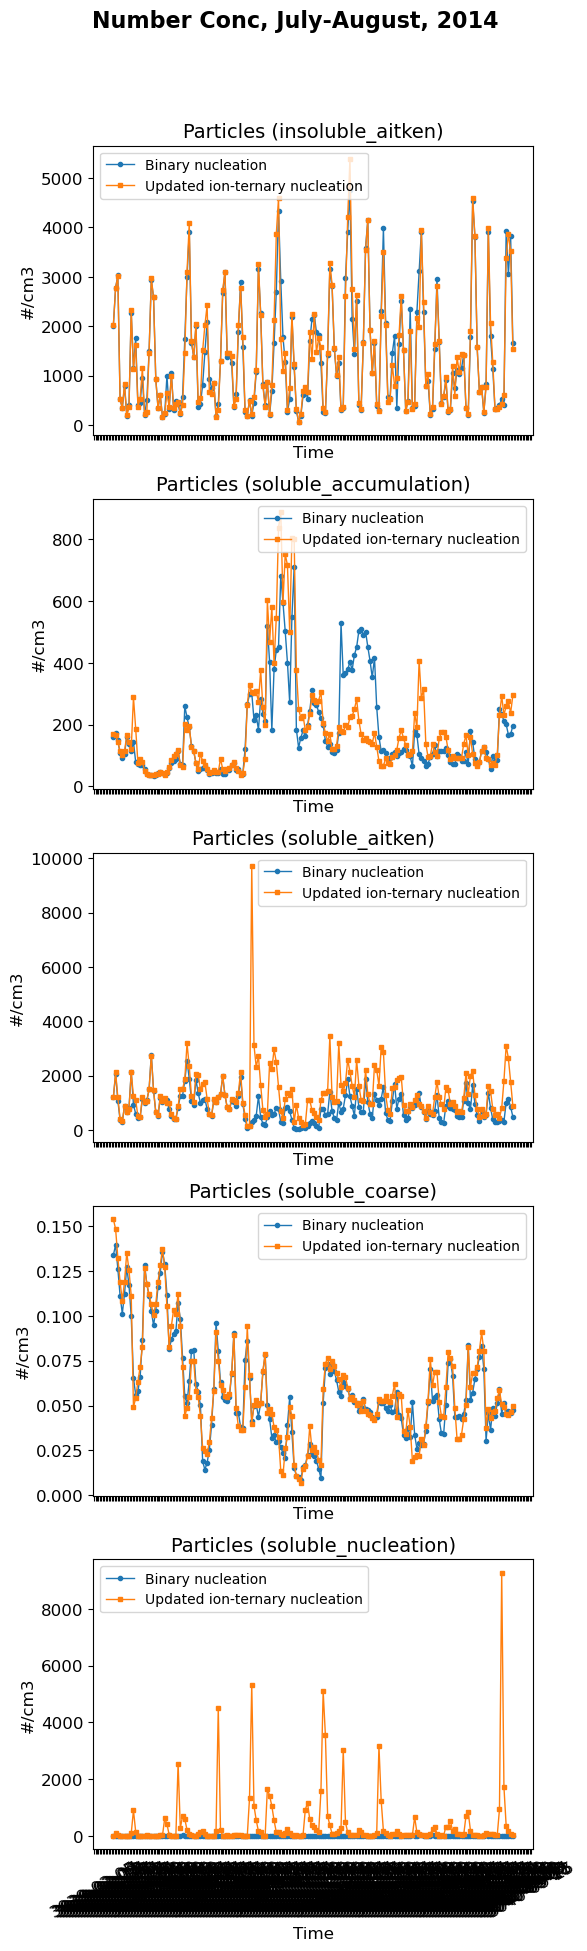

In [ ]:
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import numpy as np
import iris
import iris.coord_systems as cs
import iris.coord_systems as coord_systems

os.environ["OPENBLAS_NUM_THREADS"] = "8"

def bbox_extract_2Dcoords(cube, bbox):
    minmax = lambda x: (np.min(x), np.max(x))
    lons = cube.coord('longitude').points 
    lats = cube.coord('latitude').points
    inregion = np.logical_and(np.logical_and(lons > bbox[0],
                                             lons < bbox[1]),
                              np.logical_and(lats > bbox[2],
                                             lats < bbox[3]))
    region_inds = np.where(inregion)
    imin, imax = minmax(region_inds[0])
    jmin, jmax = minmax(region_inds[1])
    return cube[..., imin:imax+1, jmin:jmax+1]

def add_lat_lon(cube, bbox):
    polelat = cube.coord('grid_longitude').coord_system.grid_north_pole_latitude
    polelon = cube.coord('grid_longitude').coord_system.grid_north_pole_longitude  

    source_lon = cube.coord('grid_longitude').points
    source_lat = cube.coord('grid_latitude').points
    lat2d = np.transpose(np.tile(source_lat,[len(source_lon),1]))
    lon2d = np.tile(source_lon,[len(source_lat),1])

    lons, lats = iris.analysis.cartography.unrotate_pole(lon2d, lat2d, polelon, polelat)

    longit = iris.coords.AuxCoord(lons,'longitude', units='degrees', coord_system=cs.GeogCS(6371229.0))
    latit =  iris.coords.AuxCoord(lats,'latitude', units='degrees', coord_system=cs.GeogCS(6371229.0))
    
    i_test = 1 # a label for turn-on/off 
    if i_test == 0:
        # Determine the dimensions to add the latitude and longitude coordinates
        dims = tuple(range(cube.ndim))
        for dim in ('time', 'model_level_number', 'grid_latitude', 'grid_longitude'):
            if dim in cube.dim_coords:
                dims = tuple(d for d in dims if d != cube.coord_dims(dim)[0])

    cube.add_aux_coord(longit, (2,3)) 
    cube.add_aux_coord(latit, (2,3))

    return bbox_extract_2Dcoords(cube, bbox)

def read_pt_data(potential_temperature_file, air_pressure_file, bbox):
    potential_temperature_cube = iris.load_cube(potential_temperature_file)
    air_pressure_cube = iris.load_cube(air_pressure_file)
    print(potential_temperature_cube.coord('grid_longitude').points.min(), potential_temperature_cube.coord('grid_longitude').points.max())
    print(potential_temperature_cube.coord('grid_latitude').points.min(), potential_temperature_cube.coord('grid_latitude').points.max())
    print(potential_temperature_cube.units) # K
    print(air_pressure_cube.units) #Pa

    # Add the latitude and longitude coordinates to the cubes
    potential_temperature_cube = add_lat_lon(potential_temperature_cube, bbox)
    air_pressure_cube = add_lat_lon(air_pressure_cube, bbox)
    return potential_temperature_cube, air_pressure_cube

# a subroutine to convert theta to T(k)
def convert_theta_to_temperature(potential_temperature, air_pressure):
    p0 = iris.coords.AuxCoord(100000.0, long_name='reference_pressure', units='Pa')
    Rd_cp = 287.05 / 1004.0  
    air_pressure_ratio = air_pressure/p0
    air_pressure_ratio.convert_units('1')
    temperature = potential_temperature*(air_pressure_ratio)**(Rd_cp)
    # now the T looks correct, in 280~, so I commented it out now
    # for i, temp in enumerate(temperature.data.flatten()):
    #     print(f'Temperature at grid point {i+1}: {temp:.2f} K')       
    return temperature

# a subroutine to convert from kg/kg to molecule cm-3
def mixing_ratio_to_number_concentration(mixing_ratio_data, air_pressure, actual_temperature):
    zboltz = 1.3807E-23  # (J/K) R = k * N_A, k=J/K, Avogadro's number (N_A)=6.022 x 10²³ entities/mol.
    staird = air_pressure / (actual_temperature * zboltz * 1.0E6)  # 1.0E6 from m3 to cm3, another form of ideal gas law
    number_concentration = mixing_ratio_data * staird
    number_concentration.units = 'molecule cm-3'
    return number_concentration

#the new traditional iris method is under test.
def process_single_file(filename, air_pressure, actual_temperature, bbox):
    variable_name = filename.split('/')[-1].split('_')[1:-1]
    variable_data_cube = iris.load_cube(filename, '_'.join(variable_name))
    variable_data_cube = add_lat_lon(variable_data_cube, bbox)

    number_concentration_data = mixing_ratio_to_number_concentration(variable_data_cube, air_pressure, actual_temperature)
    number_concentration_mean = number_concentration_data.collapsed(['grid_latitude', 'grid_longitude'], iris.analysis.MEAN)
    number_concentration_mean = number_concentration_mean.extract(iris.Constraint(model_level_number=2))

    time_data = variable_data_cube.coord('time')
    time_data_value = time_data.points
    
    # print("Number concentration mean shape:", number_concentration_mean.shape)
    # print("Time data value shape:", time_data_value.shape)

    return number_concentration_mean, time_data_value


def process_nc_files(filenames, air_pressure, actual_temperature, bbox):
    number_concentration_mean_values = []
    time_data_values = []
    for filename in filenames:
        number_concentration_mean_value, time_data_value = process_single_file(filename, air_pressure, actual_temperature, bbox)
        number_concentration_mean_values.append(number_concentration_mean_value)
        time_data_values.append(time_data_value)
    return number_concentration_mean_values, time_data_values


def plot_data(time_data_values, number_concentration_mean_values, filenames):
    fig, axes = plt.subplots(5, 1, figsize=(6, 20), sharex=True)
    colors = ['tab:blue', 'tab:orange']
    markers = ['o', 's']
    labels = ['Binary nucleation', 'Updated ion-ternary nucleation']

    for i in range(5):
        print("time_data_values[i].dimension",time_data_values[i])
        print("number_concentration_mean_values[i][0].data.dimension",number_concentration_mean_values[i].data)
        axes[i].plot(time_data_values[i], number_concentration_mean_values[i].data, label=labels[0], color=colors[0], marker=markers[0], markersize=3, linewidth=1)
        axes[i].plot(time_data_values[i+5], number_concentration_mean_values[i+5].data, label=labels[1], color=colors[1], marker=markers[1], markersize=3, linewidth=1)

        variable_name = filenames[i].split('/')[-1].split('_')[8:10]
        variable_name = '_'.join(variable_name)
        title = filenames[i].split('/')[-1].split('_')[3].capitalize() + ' (' + variable_name + ')'
        axes[i].set_title(title, fontsize=14)

        axes[i].tick_params(axis='both', labelsize=12)
        axes[i].set_xlabel('Time', fontsize=12)
        axes[i].set_ylabel('#/cm3', fontsize=12)
        axes[i].legend()

    fig.suptitle('Number Conc, July-August, 2014', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.xticks(rotation=30)
    plt.show()


# Now need to read in the file
path_ct706 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-ct706/full_nc_files/" #i_nuc=2
path_cs093 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-cs093/full_nc_files/" #i_nuc=4

filenames = [
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc'
]

potential_temperature_file_ct706 = path_ct706 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_ct706 = path_ct706 + 'Rgn_air_pressure_m01s00i408.nc'

potential_temperature_file_cs093 = path_cs093 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_cs093 = path_cs093 + 'Rgn_air_pressure_m01s00i408.nc'

# Define the bounding box (in degrees) for the area of interest
bbox = [-105, -104.5, 40.4, 40.8] # low-altitude region, near BAO tower
# bbox = [-105, -104.5, 40.4, 40.8] # low-altitude region, near BAO tower
potential_temperature_ct706, air_pressure_ct706 = read_pt_data(potential_temperature_file_ct706, air_pressure_file_ct706, bbox)
actual_temperature_ct706 = convert_theta_to_temperature(potential_temperature_ct706, air_pressure_ct706)

potential_temperature_cs093, air_pressure_cs093 = read_pt_data(potential_temperature_file_cs093, air_pressure_file_cs093, bbox)
actual_temperature_cs093 = convert_theta_to_temperature(potential_temperature_cs093, air_pressure_cs093)

number_concentration_mean_values_ct706, time_data_values_ct706 = process_nc_files(filenames[:5], air_pressure_ct706, actual_temperature_ct706, bbox)
number_concentration_mean_values_cs093, time_data_values_cs093 = process_nc_files(filenames[5:], air_pressure_cs093, actual_temperature_cs093, bbox)
number_concentration_mean_values = number_concentration_mean_values_ct706 + number_concentration_mean_values_cs093
time_data_values = time_data_values_ct706 + time_data_values_cs093

plot_data(time_data_values, number_concentration_mean_values, filenames[:5] + filenames[5:])



In [ ]:
# so previous code cell is for testing in jupyter lab, but it takes so much time; instead I used .py and run it in terminal;
# the code is in /ocean/projects/atm200005p/ding0928/scripts/time_series_dask_working.py
# no big difference between .py and .ipynb, but .py is faster

/tmp/ipykernel_2057147/2242243851.py:56: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  potential_temperature_cube = iris.load_cube(potential_temperature_file)
/tmp/ipykernel_2057147/2242243851.py:57: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  air_pressure_cube = iris.load_cube(air_pressure_file)
/tmp/ipykernel_2057147/2242243851.py:56: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  potential_temperature_cube = iris.load_cube(potential_temperature_file)
/tmp/ipykernel_2057

357.273 362.673
-2.727 2.673
K
Pa
357.273 362.673
-2.727 2.673
K
Pa


/jet/home/ding0928/.conda/envs/iris_3.9_vscode/lib/python3.9/site-packages/iris/cube.py:3817: UserWarning: Collapsing spatial coordinate 'grid_latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/jet/home/ding0928/.conda/envs/iris_3.9_vscode/lib/python3.9/site-packages/iris/coords.py:2226: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'grid_latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'grid_latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/jet/home/ding0928/.conda/envs/iris_3.9_vscode/lib/python3.9/site-packages/iris/coords.py:2226: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'grid_longitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'grid_longitude'. Ignoring bounds.
  warnings.warn(msg.format(str

time_data_values[i].data [390505. 390508. 390511. 390514. 390517. 390520. 390523. 390526. 390529.
 390532. 390535. 390538. 390541. 390544. 390547. 390550. 390553. 390556.
 390559. 390562. 390565. 390568. 390571. 390574. 390577. 390580. 390583.
 390586. 390589. 390592. 390595. 390598. 390601. 390604. 390607. 390610.
 390613. 390616. 390619. 390622. 390625. 390628. 390631. 390634. 390637.
 390640. 390643. 390646. 390649. 390652. 390655. 390658. 390661. 390664.
 390667. 390670. 390673. 390676. 390679. 390682. 390685. 390688. 390691.
 390694. 390697. 390700. 390703. 390706. 390709. 390712. 390715. 390718.
 390721. 390724. 390727. 390730. 390733. 390736. 390739. 390742. 390745.
 390748. 390751. 390754. 390757. 390760. 390763. 390766. 390769. 390772.
 390775. 390778. 390781. 390784. 390787. 390790. 390793. 390796. 390799.
 390802. 390805. 390808. 390811. 390814. 390817. 390820. 390823. 390826.
 390829. 390832. 390835. 390838. 390841. 390844. 390847. 390850. 390853.
 390856. 390859. 390862. 3

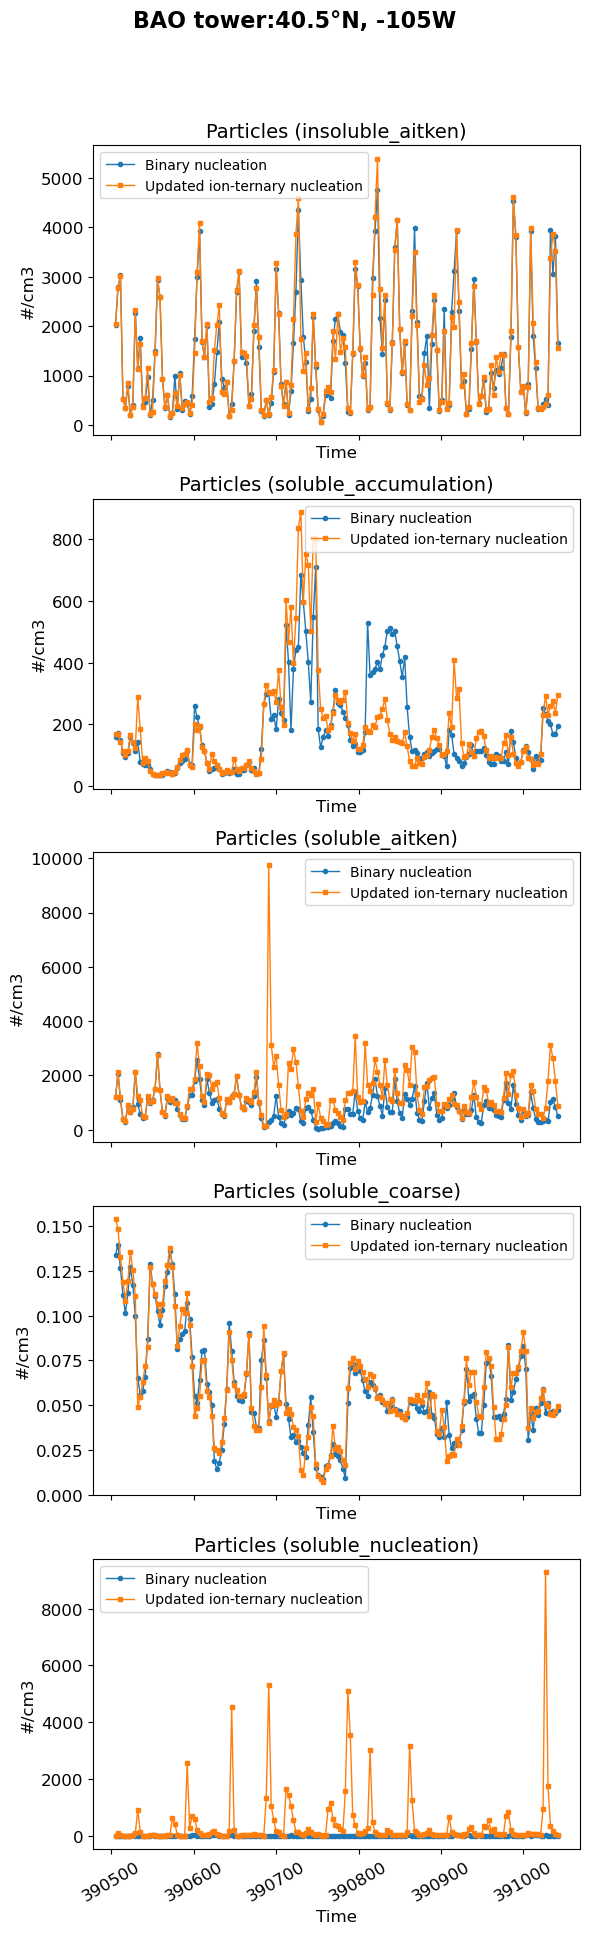

<Figure size 640x480 with 0 Axes>

In [ ]:
# %load /ocean/projects/atm200005p/ding0928/script_full_nc/time_series_dask_working.py
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import numpy as np
import iris
import iris.coord_systems as cs
import iris.coord_systems as coord_systems
import datetime

os.environ["OPENBLAS_NUM_THREADS"] = "8"

def bbox_extract_2Dcoords(cube, bbox):
    minmax = lambda x: (np.min(x), np.max(x))
    lons = cube.coord('longitude').points 
    lats = cube.coord('latitude').points
    inregion = np.logical_and(np.logical_and(lons > bbox[0],
                                             lons < bbox[1]),
                              np.logical_and(lats > bbox[2],
                                             lats < bbox[3]))
    region_inds = np.where(inregion)
    imin, imax = minmax(region_inds[0])
    jmin, jmax = minmax(region_inds[1])
    return cube[..., imin:imax+1, jmin:jmax+1]

def add_lat_lon(cube, bbox):
    polelat = cube.coord('grid_longitude').coord_system.grid_north_pole_latitude
    polelon = cube.coord('grid_longitude').coord_system.grid_north_pole_longitude  

    source_lon = cube.coord('grid_longitude').points
    source_lat = cube.coord('grid_latitude').points
    lat2d = np.transpose(np.tile(source_lat,[len(source_lon),1]))
    lon2d = np.tile(source_lon,[len(source_lat),1])

    lons, lats = iris.analysis.cartography.unrotate_pole(lon2d, lat2d, polelon, polelat)
    longit = iris.coords.AuxCoord(lons,'longitude', units='degrees', coord_system=cs.GeogCS(6371229.0))
    latit =  iris.coords.AuxCoord(lats,'latitude', units='degrees', coord_system=cs.GeogCS(6371229.0))
    
    i_test = 1 # a label for turn-on/off 
    if i_test == 0:
        # Determine the dimensions to add the latitude and longitude coordinates
        dims = tuple(range(cube.ndim))
        for dim in ('time', 'model_level_number', 'grid_latitude', 'grid_longitude'):
            if dim in cube.dim_coords:
                dims = tuple(d for d in dims if d != cube.coord_dims(dim)[0])

    cube.add_aux_coord(longit, (2,3)) 
    cube.add_aux_coord(latit, (2,3))
    return bbox_extract_2Dcoords(cube, bbox)

def read_pt_data(potential_temperature_file, air_pressure_file, bbox):
    potential_temperature_cube = iris.load_cube(potential_temperature_file)
    air_pressure_cube = iris.load_cube(air_pressure_file)
    print(potential_temperature_cube.coord('grid_longitude').points.min(), potential_temperature_cube.coord('grid_longitude').points.max())
    print(potential_temperature_cube.coord('grid_latitude').points.min(), potential_temperature_cube.coord('grid_latitude').points.max())
    print(potential_temperature_cube.units) # K
    print(air_pressure_cube.units) #Pa

    # Add the latitude and longitude coordinates to the cubes
    potential_temperature_cube = add_lat_lon(potential_temperature_cube, bbox)
    air_pressure_cube = add_lat_lon(air_pressure_cube, bbox)
    return potential_temperature_cube, air_pressure_cube

# a subroutine to convert theta to T(k)
def convert_theta_to_temperature(potential_temperature, air_pressure):
    p0 = iris.coords.AuxCoord(100000.0, long_name='reference_pressure', units='Pa')
    Rd_cp = 287.05 / 1004.0  
    air_pressure_ratio = air_pressure/p0
    air_pressure_ratio.convert_units('1')
    temperature = potential_temperature*(air_pressure_ratio)**(Rd_cp)
    # now the T looks correct, in 280~, so I commented it out now
#     for i, temp in enumerate(temperature.data.flatten()):
#         print(f'Temperature at grid point {i+1}: {temp:.2f} K')       
    return temperature

# to convert from kg/kg to molecule cm-3
def mixing_ratio_to_number_concentration(mixing_ratio_data, air_pressure, actual_temperature):
    zboltz = 1.3807E-23  # (J/K) R = k * N_A, k=J/K, Avogadro's number (N_A)=6.022 x 1023 entities/mol.
    staird = air_pressure / (actual_temperature * zboltz * 1.0E6)  # 1.0E6 from m3 to cm3, another form of ideal gas law
    number_concentration = mixing_ratio_data * staird
    number_concentration.units = 'molecule cm-3'
    return number_concentration

#iris to process one single file
def process_single_file(filename, air_pressure, actual_temperature, bbox):
    variable_name = filename.split('/')[-1].split('_')[1:-1]
    variable_data_cube = iris.load_cube(filename, '_'.join(variable_name))
    variable_data_cube = add_lat_lon(variable_data_cube, bbox)
    # Select only the vertical levels (bottom 1-10)
    # variable_data_cube = variable_data_cube.extract(iris.Constraint(model_level_number=lambda x: 1 <= x <= 10))
    number_concentration_data = mixing_ratio_to_number_concentration(variable_data_cube, air_pressure, actual_temperature)
    number_concentration_mean = number_concentration_data.collapsed(['grid_latitude', 'grid_longitude'], iris.analysis.MEAN)
    number_concentration_mean = number_concentration_mean.extract(iris.Constraint(model_level_number=2))
    time_data = variable_data_cube.coord('time')
    time_data_value = time_data.points
    return number_concentration_mean, time_data_value

# to process all the files within a loop
def process_nc_files(filenames, air_pressure, actual_temperature, bbox):
    number_concentration_mean_values = []
    time_data_values = []
    for filename in filenames:
        number_concentration_mean_value, time_data_value = process_single_file(filename, air_pressure, actual_temperature, bbox)
        number_concentration_mean_values.append(number_concentration_mean_value)
        time_data_values.append(time_data_value)
    return number_concentration_mean_values, time_data_values

def plot_data(time_data_values, number_concentration_mean_values, filenames):
    fig, axes = plt.subplots(5, 1, figsize=(6, 20), sharex=True)
    colors = ['tab:blue', 'tab:orange']
    markers = ['o', 's']
    labels = ['Binary nucleation', 'Updated ion-ternary nucleation']
         
    for i in range(5):  
        print("time_data_values[i].data",time_data_values[i])
        # print("number_concentration_mean_values[i][0].data.dimension",number_concentration_mean_values[i].data)
        axes[i].plot(time_data_values[i], number_concentration_mean_values[i].data, label=labels[0], color=colors[0], marker=markers[0], markersize=3, linewidth=1)
        axes[i].plot(time_data_values[i+5], number_concentration_mean_values[i+5].data, label=labels[1], color=colors[1], marker=markers[1], markersize=3, linewidth=1)

        variable_name = filenames[i].split('/')[-1].split('_')[8:10]
        variable_name = '_'.join(variable_name)
        title = filenames[i].split('/')[-1].split('_')[3].capitalize() + ' (' + variable_name + ')'
        axes[i].set_title(title, fontsize=14)

        axes[i].tick_params(axis='both', labelsize=12)
        axes[i].set_xlabel('Time', fontsize=12)
        axes[i].set_ylabel('#/cm3', fontsize=12)
        axes[i].legend()

    fig.suptitle('BAO tower:40.5°N, -105W', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.xticks(rotation=30)
    plt.show()
    plt.savefig('output_fig/ncfull_BAO_tower.png')

# Now need to read in the file
path_ct706 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-ct706/full_nc_files/" #i_nuc=2
path_cs093 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-cs093/full_nc_files/" #i_nuc=4

filenames = [
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc'
]

potential_temperature_file_ct706 = path_ct706 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_ct706 = path_ct706 + 'Rgn_air_pressure_m01s00i408.nc'

potential_temperature_file_cs093 = path_cs093 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_cs093 = path_cs093 + 'Rgn_air_pressure_m01s00i408.nc'
# Hamish suggested to zoom in the domain range, only 0.1 degree(4th May)
bbox = [-105, -104.5, 40.4, 40.8] #BAO tower, low altitude
#bbox = [-107, -106.5, 40.5, 40.8] #Storm Peak Lab:40.45° N, 106.6°  wester-high-altitude
potential_temperature_ct706, air_pressure_ct706 = read_pt_data(potential_temperature_file_ct706, air_pressure_file_ct706, bbox)
actual_temperature_ct706 = convert_theta_to_temperature(potential_temperature_ct706, air_pressure_ct706)

potential_temperature_cs093, air_pressure_cs093 = read_pt_data(potential_temperature_file_cs093, air_pressure_file_cs093, bbox)
actual_temperature_cs093 = convert_theta_to_temperature(potential_temperature_cs093, air_pressure_cs093)

number_concentration_mean_values_ct706, time_data_values_ct706 = process_nc_files(filenames[:5], air_pressure_ct706, actual_temperature_ct706, bbox)
number_concentration_mean_values_cs093, time_data_values_cs093 = process_nc_files(filenames[5:], air_pressure_cs093, actual_temperature_cs093, bbox)
number_concentration_mean_values = number_concentration_mean_values_ct706 + number_concentration_mean_values_cs093
time_data_values = time_data_values_ct706 + time_data_values_cs093

plot_data(time_data_values, number_concentration_mean_values, filenames[:5] + filenames[5:])


/tmp/ipykernel_96450/532294160.py:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(file_path, delim_whitespace=True, skiprows=74, error_bad_lines=False)


0        5974.9
1        5255.5
2        4941.8
3        7173.6
4       10969.0
         ...   
1483     1479.0
1484     3282.5
1485     6190.9
1486     7810.8
1487     2194.5
Name: particle_number_concentration, Length: 1488, dtype: float64
top3_dates_str ['20140723', '20140722', '20140803']
date_str: 20140723
start: 20140723000000
end: 20140724000000
daily_mean_val: 5986.9375
arrow_x: 16274.5
date_str: 20140722
start: 20140722000000
end: 20140723000000
daily_mean_val: 4513.533333333334
arrow_x: 16273.5
date_str: 20140803
start: 20140803000000
end: 20140804000000
daily_mean_val: 4171.1875
arrow_x: 16285.5


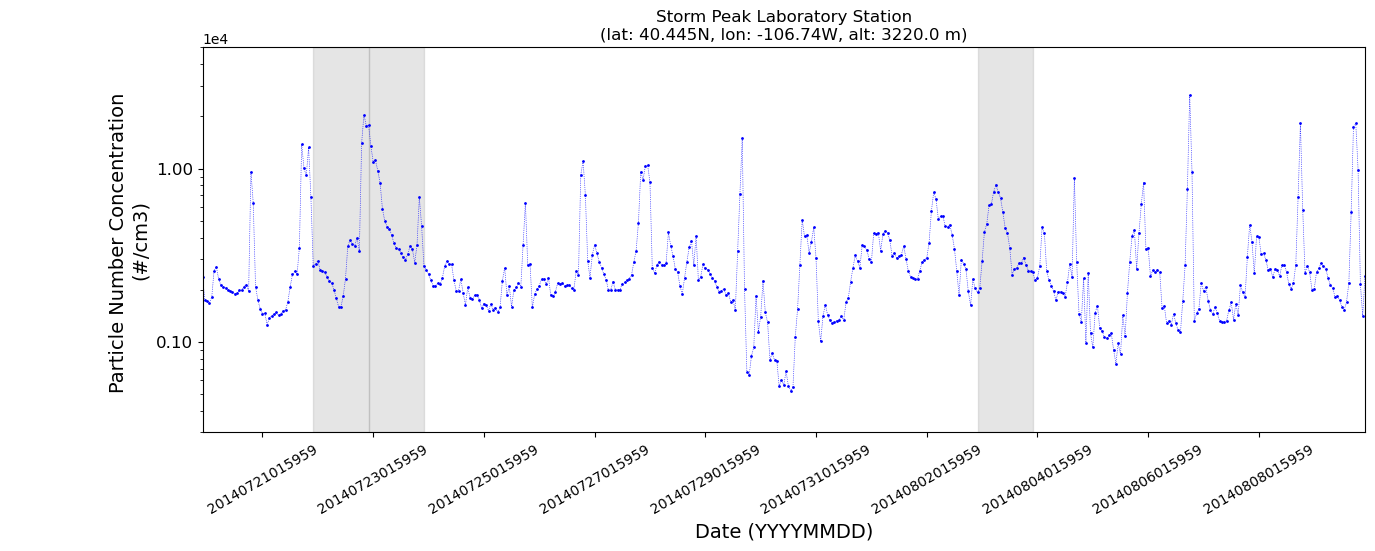

<Figure size 640x480 with 0 Axes>

In [27]:
# function version for stormpeak lab, can pick the top 3 days of maximum daily mean number concentration, but the arrow is not working yet.
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime
import matplotlib.offsetbox as offsetbox

def read_data(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True, skiprows=74, error_bad_lines=False)
    ref_date = pd.to_datetime('2014-01-01')
    df['date'] = ref_date + pd.to_timedelta(df['starttime'], unit='D')
    df['date'] = df['date'].dt.strftime('%Y%m%d%H%M%S')
    # print(df['date'])
    print(df['particle_number_concentration'])
    return df

def plot_data(df):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df['date'], df['particle_number_concentration'], 'bo', markersize=1.0)
    ax.plot(df['date'], df['particle_number_concentration'], ':', color='blue', linewidth=0.5)
    ax.set_xlabel('Date (YYYYMMDD)', fontsize=14)
    ax.set_ylabel('Particle Number Concentration \n(#/cm3)', fontsize=14)
    ax.set_title('Storm Peak Laboratory Station\n(lat: 40.445N, lon: -106.74W, alt: 3220.0 m)')

    locator = mdates.DayLocator(interval=48)
    ax.xaxis.set_major_locator(locator)
    plt.xticks(rotation=30)
    ax.set_yscale('log')
    ax.set_ylim([3e2, 5e4])
    ax.set_xlim(pd.Timestamp('2014-07-20').strftime('%Y%m%d%H%M%S'), pd.Timestamp('2014-08-10').strftime('%Y%m%d%H%M%S'))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.get_major_formatter().set_powerlimits((0, 4))
    ax.tick_params(axis='y', labelsize=12)
    return ax

def add_shaded_regions(ax, df):
    #Now I want to add a shaded region for the top 3 days of maximum daily mean number concentration
    # step 1:calculate the daily mean number concentration
    df['date'] = pd.to_datetime(df['date'])
    daily_mean = df.groupby(pd.Grouper(key='date', freq='D'))['particle_number_concentration'].mean()
    # step 2: get the top 3 days of maximum daily mean number concentration
    df = df.set_index(pd.DatetimeIndex(df['date']))
    daily_mean = daily_mean.loc['2014-07-20':'2014-08-10']
    top3_dates = daily_mean.nlargest(3).index
    top3_dates_str = [d.strftime('%Y%m%d') for d in top3_dates]
    print('top3_dates_str',top3_dates_str)    # ['20140723', '20140722', '20140803']
    # step 3: add shaded regions for the top 3 days of maximum daily mean number concentration failed!

    #version 3 for arrow:
    for date_str in top3_dates_str:
        start = pd.Timestamp(date_str).strftime('%Y%m%d%H%M%S')
        end = pd.Timestamp(date_str) + pd.Timedelta(days=1)
        end = end.strftime('%Y%m%d%H%M%S')
        ax.axvspan(start, end, alpha=0.2, color='gray')

        # get the daily mean value for the shaded region
        daily_mean_val = daily_mean[date_str]
        daily_mean.index = pd.to_datetime(daily_mean.index)

        arrow_x = pd.to_datetime(start) + pd.to_timedelta((pd.to_datetime(end) - pd.to_datetime(start)) / 2)
        arrow_x = mdates.date2num(arrow_x)  # Convert datetime object to matplotlib date number

        print('date_str:', date_str)
        print('start:', start)
        print('end:', end)
        print('daily_mean_val:', daily_mean_val)
        print('arrow_x:', arrow_x)

        try:
            offset_box = offsetbox.AnnotationBbox(offsetbox.TextArea(f'mean = {daily_mean_val:.2f}'), 
                                                    xy=(arrow_x, daily_mean_val), 
                                                    xybox=(arrow_x, daily_mean_val), 
                                                    boxcoords="data", 
                                                    arrowprops=dict(facecolor='black', arrowstyle='->', 
                                                                    connectionstyle='arc3,rad=0.2', relpos=(0.5, 0.5), 
                                                                    mutation_scale=15), 
                                                    pad=0.5)
            ax.add_artist(offset_box)
        except Exception as e:
            print('Error adding annotation:', e)
file_path = '/ocean/projects/atm200005p/ding0928/nc_file_full/Storm_Peak_julaug_2014.nas'
df = read_data(file_path)
ax = plot_data(df)
add_shaded_regions(ax, df)
plt.show()
plt.savefig('output_fig/obser_storm_peak.png', dpi=800)


smps_time_datetime_list.value [datetime.datetime(2014, 7, 25, 0, 20, 5)
 datetime.datetime(2014, 7, 25, 0, 25, 5)
 datetime.datetime(2014, 7, 25, 0, 30, 5) ...
 datetime.datetime(2014, 8, 8, 23, 45, 14)
 datetime.datetime(2014, 8, 8, 23, 50, 15)
 datetime.datetime(2014, 8, 8, 23, 55, 15)]
smps_time_datetime_list.type <class 'numpy.ndarray'>
smps_time_datetime_list.type <class 'numpy.ndarray'>
smps_time_datetime_list <class 'numpy.ndarray'>
df[date] <class 'pandas.core.series.Series'>
top3_dates DatetimeIndex(['2014-07-30', '2014-08-01', '2014-07-31'], dtype='datetime64[ns]', name='date', freq=None)
top3_dates_str ['2014-07-30', '2014-08-01', '2014-07-31']
start: 16281.0
end: 16282.0
start: 16283.0
end: 16284.0
start: 16282.0
end: 16283.0


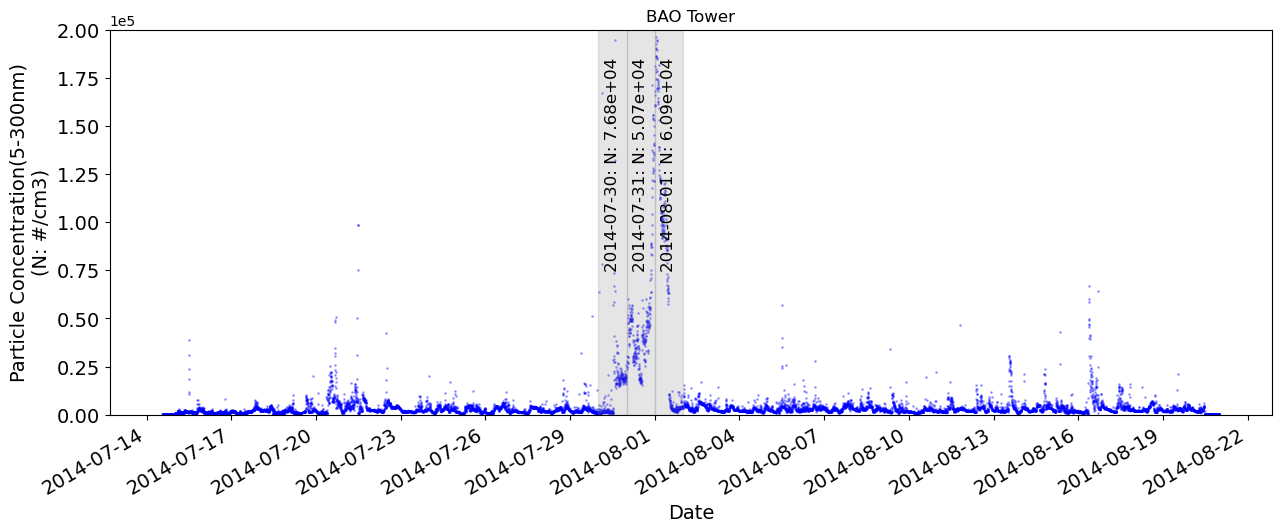

<Figure size 640x480 with 0 Axes>

In [37]:
#For BAO tower,testing the shaded grey area for BAO tower function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import os
import matplotlib
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter

def read_data(file_dir):
    smps_integrated_list = []
    smps_time_datetime_list = []
    for filename in os.listdir(file_dir):       
        if filename.endswith('.ict'):
            with open(os.path.join(file_dir, filename)) as f:
                header_lines = [f.readline() for i in range(7)]
            year, month, day = map(int, header_lines[6].split(',')[0:3]) # the date is in the 6th line
            data = np.loadtxt(os.path.join(file_dir, filename), delimiter=',', skiprows=88)
            smps_integrated_list = np.concatenate((smps_integrated_list, data[:, 3]))
            epoch = datetime.datetime(year, month, day)
            # here: to test the shaded area "date is not in the same format" issue;
            smps_time_datetime = [epoch+ datetime.timedelta(seconds=time_str) for time_str in data[:, 0]] 
            smps_time_datetime_list = np.concatenate((smps_time_datetime_list, smps_time_datetime))
    print('smps_time_datetime_list.value', smps_time_datetime_list)
    print('smps_time_datetime_list.type', type(smps_time_datetime_list)) #<class 'numpy.ndarray'>
    print('smps_time_datetime_list.type', type(smps_integrated_list)) #<class 'numpy.ndarray'>
    return smps_integrated_list, smps_time_datetime_list

def plot_data(smps_time_datetime_list, smps_integrated_list):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.scatter(smps_time_datetime_list, smps_integrated_list, s=1, color='blue', alpha=0.3)   
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Particle Concentration(5-300nm)\n(N: #/cm3)',fontsize=14)
    ax.set_ylim([0, 2e5])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))  
    ax.set_title('BAO Tower')
    ax.tick_params(axis='y', labelsize=14)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.tick_params(axis='x', labelsize=14)
    plt.xticks(rotation=30, ha='right')
    print('smps_time_datetime_list',type(smps_time_datetime_list)) # <class 'numpy.ndarray'>

    # Add shaded regions for the top 3 days of maximum daily mean number concentration
    df = pd.DataFrame({'date': smps_time_datetime_list, 'particle_number_concentration': smps_integrated_list}) #pandas DataFrame df
    df['date'] = pd.to_datetime(df['date'])# datetime format 
    print('df[date]',type(df['date'])) #df[date] <class 'pandas.core.series.Series'>
    daily_mean = df.groupby(pd.Grouper(key='date', freq='D'))['particle_number_concentration'].mean() #"date" column of the df DataFrame.
    daily_mean = daily_mean.loc[df['date'].min():df['date'].max()]
    top3_dates = daily_mean.nlargest(3).index
    print('top3_dates',top3_dates)
    top3_dates_str = [d.strftime('%Y-%m-%d') for d in top3_dates] # from datetime format to string format 
    print('top3_dates_str',top3_dates_str)    # ['20140730', '20140801', '20140731']
    for date_str in top3_dates_str:
        start_num = matplotlib.dates.date2num(pd.Timestamp(date_str))
        end_num = matplotlib.dates.date2num(pd.Timestamp(date_str) + pd.Timedelta(days=1))
        ax.axvspan(start_num, end_num, alpha=0.2, color='gray')
        ax.text(start_num + (end_num - start_num) / 2, 1.3e5, f"{date_str}: N: {daily_mean[date_str]:.2e}", ha='center', va='center', fontsize=12, rotation=90)
        print('start:', start_num)
        print('end:', end_num)
    plt.show()
 
file_path = '/ocean/projects/atm200005p/ding0928/nc_file_full/WWW-AIR_1683138523904/'
smps_integrated_list, smps_time_datetime_list = read_data(file_path)
plot_data(smps_time_datetime_list, smps_integrated_list)
plt.savefig('output_fig/obser_BAO_tower.png', dpi=800)


In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime
import matplotlib.offsetbox as offsetbox
import matplotlib
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


/tmp/ipykernel_96450/3773936562.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(file_path_storm, delim_whitespace=True, skiprows=74, error_bad_lines=False)


smps_time_datetime_list.value [datetime.datetime(2014, 7, 25, 0, 20, 5)
 datetime.datetime(2014, 7, 25, 0, 25, 5)
 datetime.datetime(2014, 7, 25, 0, 30, 5) ...
 datetime.datetime(2014, 8, 8, 23, 45, 14)
 datetime.datetime(2014, 8, 8, 23, 50, 15)
 datetime.datetime(2014, 8, 8, 23, 55, 15)]
smps_time_datetime_list.type <class 'numpy.ndarray'>
smps_time_datetime_list.type <class 'numpy.ndarray'>
top3_dates_str ['20140723', '20140722', '20140803']
smps_time_datetime_list <class 'numpy.ndarray'>
df[date] <class 'pandas.core.series.Series'>
top3_dates DatetimeIndex(['2014-07-30', '2014-08-01', '2014-07-31'], dtype='datetime64[ns]', name='date', freq=None)
top3_dates_str ['2014-07-30', '2014-08-01', '2014-07-31']
start: 16281.0
end: 16282.0
start: 16283.0
end: 16284.0
start: 16282.0
end: 16283.0


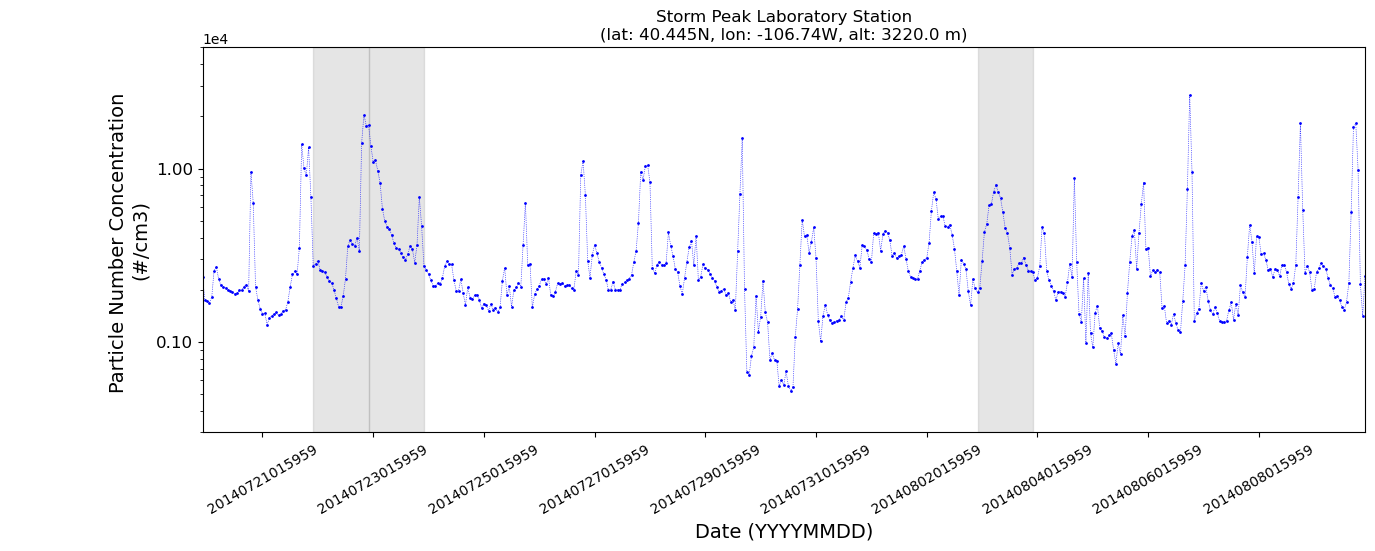

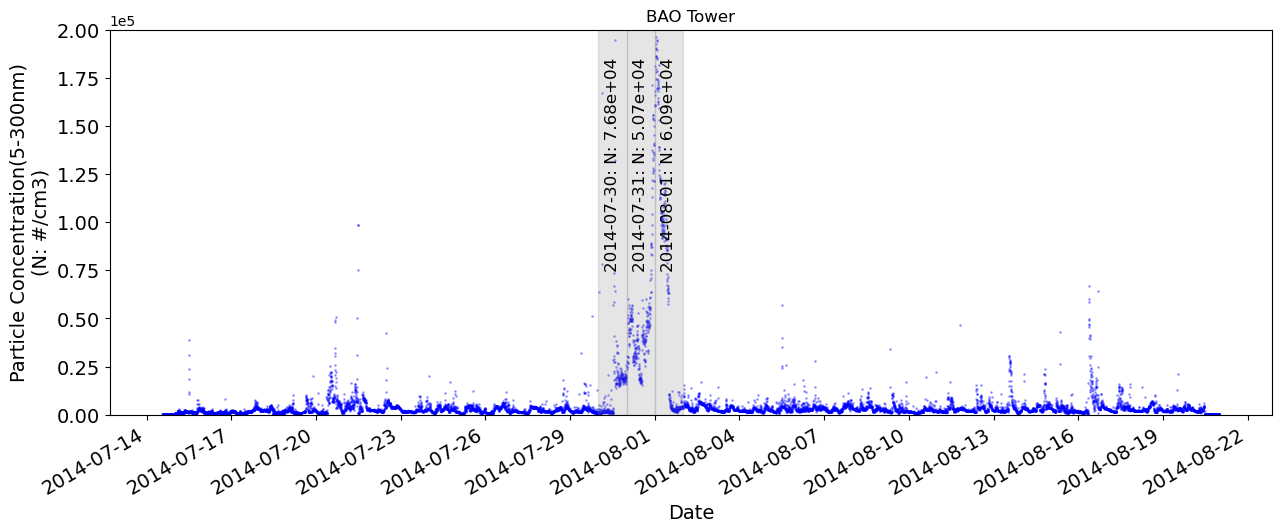

<Figure size 640x480 with 0 Axes>

In [8]:
# Now I want to merge the two functions together, old version gives me ugly figure....leave it as it be for now
# 1.1 read in stormpeak lab data
def read_data_storm(file_path_storm):
    df = pd.read_csv(file_path_storm, delim_whitespace=True, skiprows=74, error_bad_lines=False)
    ref_date = pd.to_datetime('2014-01-01')
    df['date'] = ref_date + pd.to_timedelta(df['starttime'], unit='D')
    df['date'] = df['date'].dt.strftime('%Y%m%d%H%M%S')
    return df
file_path_storm = '/ocean/projects/atm200005p/ding0928/nc_file_full/Storm_Peak_julaug_2014.nas'
df = read_data_storm(file_path_storm)
# 1.2 read in BAO tower data
def read_data_BAO(file_dir):
    smps_integrated_list = []
    smps_time_datetime_list = []
    for filename in os.listdir(file_dir):       
        if filename.endswith('.ict'):
            with open(os.path.join(file_dir, filename)) as f:
                header_lines = [f.readline() for i in range(7)]
            year, month, day = map(int, header_lines[6].split(',')[0:3]) # the date is in the 6th line
            data = np.loadtxt(os.path.join(file_dir, filename), delimiter=',', skiprows=88)
            smps_integrated_list = np.concatenate((smps_integrated_list, data[:, 3]))
            epoch = datetime.datetime(year, month, day)
            # here: to test the shaded area "date is not in the same format" issue;
            smps_time_datetime = [epoch+ datetime.timedelta(seconds=time_str) for time_str in data[:, 0]] 
            smps_time_datetime_list = np.concatenate((smps_time_datetime_list, smps_time_datetime))
    print('smps_time_datetime_list.value', smps_time_datetime_list)
    print('smps_time_datetime_list.type', type(smps_time_datetime_list)) #<class 'numpy.ndarray'>
    print('smps_time_datetime_list.type', type(smps_integrated_list)) #<class 'numpy.ndarray'>
    return smps_integrated_list, smps_time_datetime_list
file_path_BAO = '/ocean/projects/atm200005p/ding0928/nc_file_full/WWW-AIR_1683138523904/'
smps_integrated_list, smps_time_datetime_list = read_data_BAO(file_path_BAO)
# 2.1 plot stormpeak lab data
def plot_data_storm(df):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df['date'], df['particle_number_concentration'], 'bo', markersize=1.0)
    ax.plot(df['date'], df['particle_number_concentration'], ':', color='blue', linewidth=0.5)
    ax.set_xlabel('Date (YYYYMMDD)', fontsize=14)
    ax.set_ylabel('Particle Number Concentration \n(#/cm3)', fontsize=14)
    ax.set_title('Storm Peak Laboratory Station\n(lat: 40.445N, lon: -106.74W, alt: 3220.0 m)')

    locator = mdates.DayLocator(interval=48)
    ax.xaxis.set_major_locator(locator)
    plt.xticks(rotation=30)
    ax.set_yscale('log')
    ax.set_ylim([3e2, 5e4])
    ax.set_xlim(pd.Timestamp('2014-07-20').strftime('%Y%m%d%H%M%S'), pd.Timestamp('2014-08-10').strftime('%Y%m%d%H%M%S'))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.yaxis.get_major_formatter().set_powerlimits((0, 4))
    ax.tick_params(axis='y', labelsize=12)
    return ax

def add_shaded_regions_storm(ax, df):
    #Now I want to add a shaded region for the top 3 days of maximum daily mean number concentration
    df['date'] = pd.to_datetime(df['date'])
    daily_mean = df.groupby(pd.Grouper(key='date', freq='D'))['particle_number_concentration'].mean()
    df = df.set_index(pd.DatetimeIndex(df['date']))
    daily_mean = daily_mean.loc['2014-07-20':'2014-08-10']
    top3_dates = daily_mean.nlargest(3).index
    top3_dates_str = [d.strftime('%Y%m%d') for d in top3_dates]
    print('top3_dates_str',top3_dates_str)    # ['20140723', '20140722', '20140803']
    
    for date_str in top3_dates_str:
        start = pd.Timestamp(date_str).strftime('%Y%m%d%H%M%S')
        end = pd.Timestamp(date_str) + pd.Timedelta(days=1)
        end = end.strftime('%Y%m%d%H%M%S')
        ax.axvspan(start, end, alpha=0.2, color='gray')

        # get the daily mean value for the shaded region
        daily_mean_val = daily_mean[date_str]
        daily_mean.index = pd.to_datetime(daily_mean.index)

        arrow_x = pd.to_datetime(start) + pd.to_timedelta((pd.to_datetime(end) - pd.to_datetime(start)) / 2)
        arrow_x = mdates.date2num(arrow_x)  # Convert datetime object to matplotlib date number

        try:
            offset_box = offsetbox.AnnotationBbox(offsetbox.TextArea(f'mean = {daily_mean_val:.2f}'), 
                                                    xy=(arrow_x, daily_mean_val), 
                                                    xybox=(arrow_x, daily_mean_val), 
                                                    boxcoords="data", 
                                                    arrowprops=dict(facecolor='black', arrowstyle='->', 
                                                                    connectionstyle='arc3,rad=0.2', relpos=(0.5, 0.5), 
                                                                    mutation_scale=15), 
                                                    pad=0.5)
            ax.add_artist(offset_box)
        except Exception as e:
            print('Error adding annotation:', e)

ax = plot_data_storm(df)
add_shaded_regions_storm(ax, df)
plt.savefig('output_fig/obser_storm_peak.png', dpi=800)

#For BAO tower,testing the shaded grey area for BAO tower function
def plot_data_BAO(smps_time_datetime_list, smps_integrated_list):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.scatter(smps_time_datetime_list, smps_integrated_list, s=1, color='blue', alpha=0.3)   
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Particle Concentration(5-300nm)\n(N: #/cm3)',fontsize=14)
    ax.set_ylim([0, 2e5])
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))  
    ax.set_title('BAO Tower')
    ax.tick_params(axis='y', labelsize=14)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.tick_params(axis='x', labelsize=14)
    plt.xticks(rotation=30, ha='right')
    print('smps_time_datetime_list',type(smps_time_datetime_list)) # <class 'numpy.ndarray'>

    # Add shaded regions for the top 3 days of maximum daily mean number concentration
    df = pd.DataFrame({'date': smps_time_datetime_list, 'particle_number_concentration': smps_integrated_list}) #pandas DataFrame df
    df['date'] = pd.to_datetime(df['date'])# datetime format 
    print('df[date]',type(df['date'])) #df[date] <class 'pandas.core.series.Series'>
    daily_mean = df.groupby(pd.Grouper(key='date', freq='D'))['particle_number_concentration'].mean() #"date" column of the df DataFrame.
    daily_mean = daily_mean.loc[df['date'].min():df['date'].max()]
    top3_dates = daily_mean.nlargest(3).index
    print('top3_dates',top3_dates)
    top3_dates_str = [d.strftime('%Y-%m-%d') for d in top3_dates] # from datetime format to string format 
    print('top3_dates_str',top3_dates_str)    # ['20140730', '20140801', '20140731']
    # Finally figured out the reason why the shaded area is not working: the date format is not the same, one is datetime, one is string
    for date_str in top3_dates_str:
        start_num = matplotlib.dates.date2num(pd.Timestamp(date_str))
        end_num = matplotlib.dates.date2num(pd.Timestamp(date_str) + pd.Timedelta(days=1))
        ax.axvspan(start_num, end_num, alpha=0.2, color='gray')
        ax.text(start_num + (end_num - start_num) / 2, 1.3e5, f"{date_str}: N: {daily_mean[date_str]:.2e}", ha='center', va='center', fontsize=12, rotation=90)
        print('start:', start_num)
        print('end:', end_num)
    
plot_data_BAO(smps_time_datetime_list, smps_integrated_list)
plt.show()
plt.savefig('output_fig/obser_BAO_tower.png', dpi=800)

In [1]:
def read_data_storm(file_path_storm):
    df = pd.read_csv(file_path_storm, delim_whitespace=True, skiprows=74, error_bad_lines=False)
    ref_date = pd.to_datetime('2014-01-01')
    df['date'] = ref_date + pd.to_timedelta(df['starttime'], unit='D')
    df['date'] = df['date'].dt.strftime('%Y%m%d%H%M%S') # in hourly format
    return df
file_path_storm = '/ocean/projects/atm200005p/ding0928/nc_file_full/Storm_Peak_julaug_2014.nas'
df = read_data_storm(file_path_storm)

def read_data_BAO(file_dir):
    smps_integrated_list = [] # in 5-min format
    smps_time_datetime_list = []
    for filename in os.listdir(file_dir):       
        if filename.endswith('.ict'):
            with open(os.path.join(file_dir, filename)) as f:
                header_lines = [f.readline() for i in range(7)]
            year, month, day = map(int, header_lines[6].split(',')[0:3]) # the date is in the 6th line
            data = np.loadtxt(os.path.join(file_dir, filename), delimiter=',', skiprows=88)
            smps_integrated_list = np.concatenate((smps_integrated_list, data[:, 3]))
            epoch = datetime.datetime(year, month, day)
            smps_time_datetime = [epoch+ datetime.timedelta(seconds=time_str) for time_str in data[:, 0]] 
            smps_time_datetime_list = np.concatenate((smps_time_datetime_list, smps_time_datetime))
    return smps_integrated_list, smps_time_datetime_list
file_path_BAO = '/ocean/projects/atm200005p/ding0928/nc_file_full/WWW-AIR_1683138523904/'
smps_integrated_list, smps_time_datetime_list = read_data_BAO(file_path_BAO)

def process_data(df, smps_integrated_list, smps_time_datetime_list):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S')
    df = df.set_index('date')
    df = df.reindex(smps_time_datetime_list)
    df_interpolated = df.interpolate(method='linear')
    smps_interpolated = pd.Series(smps_integrated_list, index=smps_time_datetime_list).interpolate(method='linear')
    return df_interpolated, smps_interpolated

def plot_data(df, smps_integrated_list, smps_time_datetime_list):
    df_resampled, smps_resampled = process_data(df, smps_integrated_list, smps_time_datetime_list)
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df_resampled.index, df_resampled['particle_number_concentration'], color='blue', label='Storm Peak', s=5)
    ax.scatter(smps_resampled.index, smps_resampled, color='red', label='BAO Tower', s=5)

    ax.set_xlabel('Date (YYYY-MM-DD)', fontsize=14)
    ax.set_ylabel('Particle Number Concentration \n(#/cm3)', fontsize=14)
    ax.set_title('Particle Number Concentration Comparison\nStorm Peak vs BAO Tower', fontsize=16)
    ax.legend(loc='upper left', fontsize=12)
    locator = mdates.DayLocator(interval=2)
    ax.xaxis.set_major_locator(locator)
    plt.xticks(rotation=30)
    ax.set_yscale('log')
    ax.set_ylim([1e2, 4e5])
    return ax

df_resampled, smps_resampled = process_data(df, smps_integrated_list, smps_time_datetime_list)
plot_data(df, smps_integrated_list, smps_time_datetime_list)

NameError: name 'pd' is not defined

/tmp/ipykernel_643341/4228578325.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(file_path_storm, delim_whitespace=True, skiprows=74, error_bad_lines=False)


<Axes: title={'center': 'Particle Number Concentration\nStorm Peak vs BAO Tower(5-300nm)'}, xlabel='Date (YYYY-MM-DD)', ylabel='N (#/cm$^{3}$)'>

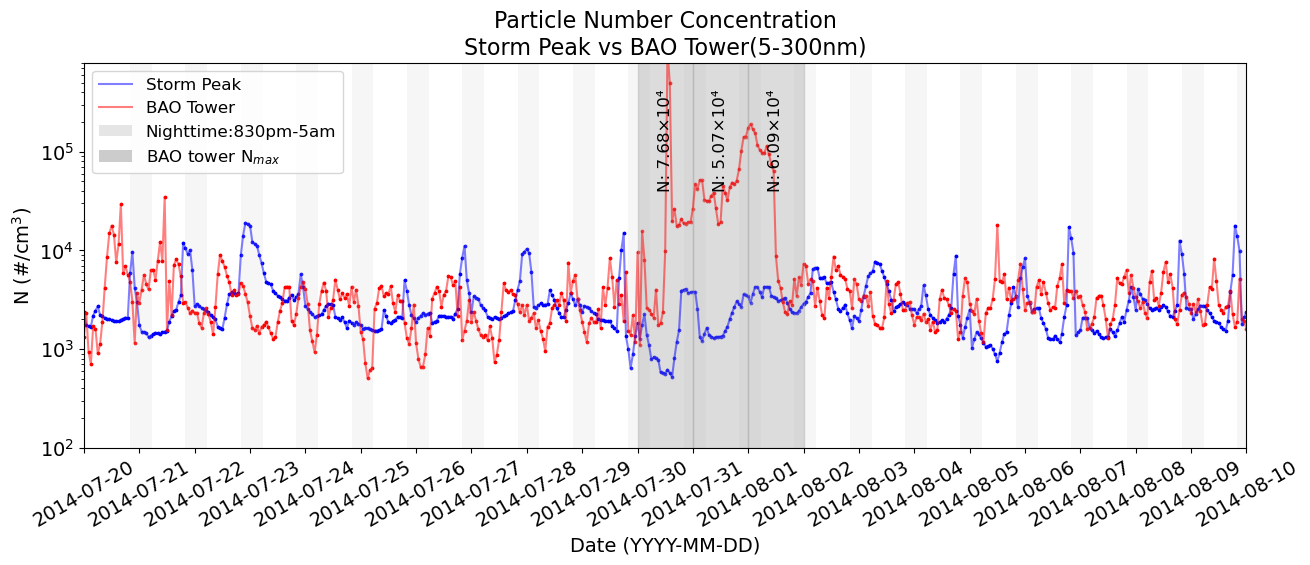

In [2]:
# doing the same thing as the above cell, but using resample instead of interpolate
def read_data_storm(file_path_storm):
    df = pd.read_csv(file_path_storm, delim_whitespace=True, skiprows=74, error_bad_lines=False)
    ref_date = pd.to_datetime('2014-01-01')
    df['date'] = ref_date + pd.to_timedelta(df['starttime'], unit='D')
    df['date'] = df['date'].dt.strftime('%Y%m%d%H%M%S') # in hourly format
    return df
file_path_storm = '/ocean/projects/atm200005p/ding0928/nc_file_full/Storm_Peak_julaug_2014.nas'
df = read_data_storm(file_path_storm)

def read_data_BAO(file_dir):
    smps_integrated_list = [] # in 5-min format
    smps_time_datetime_list = []
    for filename in os.listdir(file_dir):       
        if filename.endswith('.ict'):
            with open(os.path.join(file_dir, filename)) as f:
                header_lines = [f.readline() for i in range(7)]
            year, month, day = map(int, header_lines[6].split(',')[0:3]) # the date is in the 6th line
            data = np.loadtxt(os.path.join(file_dir, filename), delimiter=',', skiprows=88)
            smps_integrated_list = np.concatenate((smps_integrated_list, data[:, 3]))
            epoch = datetime.datetime(year, month, day)
            smps_time_datetime = [epoch+ datetime.timedelta(seconds=time_str) for time_str in data[:, 0]] 
            smps_time_datetime_list = np.concatenate((smps_time_datetime_list, smps_time_datetime))
    return smps_integrated_list, smps_time_datetime_list
file_path_BAO = '/ocean/projects/atm200005p/ding0928/nc_file_full/WWW-AIR_1683138523904/'
smps_integrated_list, smps_time_datetime_list = read_data_BAO(file_path_BAO)

def process_data(df, smps_integrated_list, smps_time_datetime_list):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H%M%S')
    smps_time_datetime_index = pd.DatetimeIndex(smps_time_datetime_list)
    df_resampled = df.set_index('date').resample('1H').mean().interpolate(method='linear')
    smps_resampled = pd.Series(smps_integrated_list, index=smps_time_datetime_index).resample('1H').mean().interpolate(method='linear')
    return df_resampled, smps_resampled

def plot_data(df, smps_integrated_list, smps_time_datetime_list):
    df_resampled, smps_resampled = process_data(df, smps_integrated_list, smps_time_datetime_list)
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(df_resampled.index, df_resampled['particle_number_concentration'], color='blue', label='Storm Peak', s=3)
    ax.plot(df_resampled.index, df_resampled['particle_number_concentration'], color='blue', alpha=0.5, label='Storm Peak') 
    ax.scatter(smps_resampled.index, smps_resampled, color='red', label='BAO Tower', s=3)
    ax.plot(smps_resampled.index, smps_resampled, color='red', alpha=0.5, label='BAO Tower')
    ax.set_xlabel('Date (YYYY-MM-DD)', fontsize=14)
    # ax.set_ylabel('N #/cm3', fontsize=14)
    ax.set_ylabel('N (#/cm$^{3}$)', fontsize=14)

    ax.set_title('Particle Number Concentration\nStorm Peak vs BAO Tower(5-300nm)', fontsize=16)
    ax.legend(loc='upper left', fontsize=12)
    locator = mdates.DayLocator(interval=1)
    ax.xaxis.set_major_locator(locator)
    plt.xticks(rotation=30)
    ax.set_yscale('log')
    ax.set_ylim([1e2, 8e5])   
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    # Set x-axis limits
    start_date = pd.to_datetime('2014-07-20')
    end_date = pd.to_datetime('2014-08-10')
    ax.set_xlim([start_date, end_date])   
    # Shade nighttime hours (8pm-5.5am) for each day
    for day in pd.date_range(start_date, end_date, freq='D'):
        day_start = pd.Timestamp(day + pd.Timedelta(hours=20))
        next_day = day + pd.Timedelta(days=1)
        day_end = pd.Timestamp(next_day + pd.Timedelta(hours=5.5))
        ax.axvspan(day_start, day_end, facecolor='lightgray', alpha=0.2)
    
    # Add shaded regions for the top 3 days of maximum daily mean number concentration
    df = pd.DataFrame({'date': smps_time_datetime_list, 'particle_number_concentration': smps_integrated_list})
    df['date'] = pd.to_datetime(df['date'])
    daily_mean = df.groupby(pd.Grouper(key='date', freq='D'))['particle_number_concentration'].mean()
    daily_mean = daily_mean.loc[df['date'].min():df['date'].max()]
    top3_dates = daily_mean.nlargest(3).index
    top3_dates_str = [d.strftime('%Y-%m-%d') for d in top3_dates]
    
    for date_str in top3_dates_str:
        start_num = matplotlib.dates.date2num(pd.Timestamp(date_str))
        end_num = matplotlib.dates.date2num(pd.Timestamp(date_str) + pd.Timedelta(days=1))
        ax.axvspan(start_num, end_num, alpha=0.4, color='darkgray')
        ax.text(start_num + (end_num - start_num) / 2, 1.3e5, f"N: {daily_mean[date_str]:.2e}".replace('e+04', '×10⁴'), ha='center', va='center', fontsize=12, rotation=90)

    # Add legend
    line1 = mlines.Line2D([], [], color='blue', alpha=0.5, label='Storm Peak')
    line2 = mlines.Line2D([], [], color='red', alpha=0.5, label='BAO Tower') 
    daytime_patch = mpatches.Patch(facecolor='gray', alpha=0.2, label='Nighttime:8:30pm-5am')
    top3_patch = mpatches.Patch(facecolor='gray', alpha=0.4, label='BAO tower N$_{max}$, top 3 days')
    ax.legend(handles=[line1, line2, daytime_patch, top3_patch], loc='upper left', fontsize=12)
    return ax

df_resampled, smps_resampled = process_data(df, smps_integrated_list, smps_time_datetime_list)
plot_data(df, smps_integrated_list, smps_time_datetime_list)

In [ ]:
# %load /ocean/projects/atm200005p/ding0928/script_full_nc/time_series_dask_working.py
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import numpy as np
import iris
import iris.coord_systems as cs
import iris.coord_systems as coord_systems

os.environ["OPENBLAS_NUM_THREADS"] = "8"

def bbox_extract_2Dcoords(cube, bbox):
    minmax = lambda x: (np.min(x), np.max(x))
    lons = cube.coord('longitude').points 
    lats = cube.coord('latitude').points
    inregion = np.logical_and(np.logical_and(lons > bbox[0],
                                             lons < bbox[1]),
                              np.logical_and(lats > bbox[2],
                                             lats < bbox[3]))
    region_inds = np.where(inregion)
    imin, imax = minmax(region_inds[0])
    jmin, jmax = minmax(region_inds[1])
    return cube[..., imin:imax+1, jmin:jmax+1]

def add_lat_lon(cube, bbox):
    polelat = cube.coord('grid_longitude').coord_system.grid_north_pole_latitude
    polelon = cube.coord('grid_longitude').coord_system.grid_north_pole_longitude  

    source_lon = cube.coord('grid_longitude').points
    source_lat = cube.coord('grid_latitude').points
    lat2d = np.transpose(np.tile(source_lat,[len(source_lon),1]))
    lon2d = np.tile(source_lon,[len(source_lat),1])

    lons, lats = iris.analysis.cartography.unrotate_pole(lon2d, lat2d, polelon, polelat)

    longit = iris.coords.AuxCoord(lons,'longitude', units='degrees', coord_system=cs.GeogCS(6371229.0))
    latit =  iris.coords.AuxCoord(lats,'latitude', units='degrees', coord_system=cs.GeogCS(6371229.0))
    
    i_test = 1 # a label for turn-on/off 
    if i_test == 0:
        # Determine the dimensions to add the latitude and longitude coordinates
        dims = tuple(range(cube.ndim))
        for dim in ('time', 'model_level_number', 'grid_latitude', 'grid_longitude'):
            if dim in cube.dim_coords:
                dims = tuple(d for d in dims if d != cube.coord_dims(dim)[0])

    cube.add_aux_coord(longit, (2,3)) 
    cube.add_aux_coord(latit, (2,3))

    return bbox_extract_2Dcoords(cube, bbox)

def read_pt_data(potential_temperature_file, air_pressure_file, bbox):
    potential_temperature_cube = iris.load_cube(potential_temperature_file)
    air_pressure_cube = iris.load_cube(air_pressure_file)
    print(potential_temperature_cube.coord('grid_longitude').points.min(), potential_temperature_cube.coord('grid_longitude').points.max())
    print(potential_temperature_cube.coord('grid_latitude').points.min(), potential_temperature_cube.coord('grid_latitude').points.max())
    print(potential_temperature_cube.units) # K
    print(air_pressure_cube.units) #Pa

    # Add the latitude and longitude coordinates to the cubes
    potential_temperature_cube = add_lat_lon(potential_temperature_cube, bbox)
    air_pressure_cube = add_lat_lon(air_pressure_cube, bbox)
    return potential_temperature_cube, air_pressure_cube

# a subroutine to convert theta to T(k)
def convert_theta_to_temperature(potential_temperature, air_pressure):
    p0 = iris.coords.AuxCoord(100000.0, long_name='reference_pressure', units='Pa')
    Rd_cp = 287.05 / 1004.0  
    air_pressure_ratio = air_pressure/p0
    air_pressure_ratio.convert_units('1')
    temperature = potential_temperature*(air_pressure_ratio)**(Rd_cp)
    # now the T looks correct, in 280~, so I commented it out now
#     for i, temp in enumerate(temperature.data.flatten()):
#         print(f'Temperature at grid point {i+1}: {temp:.2f} K')       
    return temperature

# to convert from kg/kg to molecule cm-3
def mixing_ratio_to_number_concentration(mixing_ratio_data, air_pressure, actual_temperature):
    zboltz = 1.3807E-23  # (J/K) R = k * N_A, k=J/K, Avogadro's number (N_A)=6.022 x 1023 entities/mol.
    staird = air_pressure / (actual_temperature * zboltz * 1.0E6)  # 1.0E6 from m3 to cm3, another form of ideal gas law
    number_concentration = mixing_ratio_data * staird
    number_concentration.units = 'molecule cm-3'
    return number_concentration

#iris to process one single file
def process_single_file(filename, air_pressure, actual_temperature, bbox):
    variable_name = filename.split('/')[-1].split('_')[1:-1]
    variable_data_cube = iris.load_cube(filename, '_'.join(variable_name))
    variable_data_cube = add_lat_lon(variable_data_cube, bbox)

    number_concentration_data = mixing_ratio_to_number_concentration(variable_data_cube, air_pressure, actual_temperature)
    number_concentration_mean = number_concentration_data.collapsed(['grid_latitude', 'grid_longitude'], iris.analysis.MEAN)
    number_concentration_mean = number_concentration_mean.extract(iris.Constraint(model_level_number=2))

    time_data = variable_data_cube.coord('time')
    time_data_value = time_data.points
    return number_concentration_mean, time_data_value

# to process all the files within a loop
def process_nc_files(filenames, air_pressure, actual_temperature, bbox):
    number_concentration_mean_values = []
    time_data_values = []
    for filename in filenames:
        number_concentration_mean_value, time_data_value = process_single_file(filename, air_pressure, actual_temperature, bbox)
        number_concentration_mean_values.append(number_concentration_mean_value)
        time_data_values.append(time_data_value)
    return number_concentration_mean_values, time_data_values

def plot_data(time_data_values, number_concentration_mean_values, filenames):
    fig, axes = plt.subplots(5, 1, figsize=(6, 20), sharex=True)
    colors = ['tab:blue', 'tab:orange']
    markers = ['o', 's']
    labels = ['Binary nucleation', 'Updated ion-ternary nucleation']
    
    for i in range(5):
        print("time_data_values[i].dimension",time_data_values[i])
        print("number_concentration_mean_values[i][0].data.dimension",number_concentration_mean_values[i].data)
        axes[i].plot(time_data_values[i], number_concentration_mean_values[i].data, label=labels[0], color=colors[0], marker=markers[0], markersize=3, linewidth=1)
        axes[i].plot(time_data_values[i+5], number_concentration_mean_values[i+5].data, label=labels[1], color=colors[1], marker=markers[1], markersize=3, linewidth=1)

        variable_name = filenames[i].split('/')[-1].split('_')[8:10]
        variable_name = '_'.join(variable_name)
        title = filenames[i].split('/')[-1].split('_')[3].capitalize() + ' (' + variable_name + ')'
        axes[i].set_title(title, fontsize=14)

        axes[i].tick_params(axis='both', labelsize=12)
        axes[i].set_xlabel('Time', fontsize=12)
        axes[i].set_ylabel('#/cm3', fontsize=12)
        axes[i].legend()

    fig.suptitle('BAO tower:40.5°N, -105W', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.xticks(rotation=30)
    plt.show()
    plt.savefig('BAO tower:40.5°N, -105.png')

# Now need to read in the file
path_ct706 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-ct706/full_nc_files/" #i_nuc=2
path_cs093 = "/ocean/projects/atm200005p/ding0928/nc_file_full/u-cs093/full_nc_files/" #i_nuc=4

filenames = [
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_ct706 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_insoluble_aitken_mode_aerosol_in_air_m01s34i119.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_accumulation_mode_aerosol_in_air_m01s34i107.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_aitken_mode_aerosol_in_air_m01s34i103.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_coarse_mode_aerosol_in_air_m01s34i113.nc',
    path_cs093 + 'Rgn_number_of_particles_per_air_molecule_of_soluble_nucleation_mode_aerosol_in_air_m01s34i101.nc'
]

potential_temperature_file_ct706 = path_ct706 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_ct706 = path_ct706 + 'Rgn_air_pressure_m01s00i408.nc'

potential_temperature_file_cs093 = path_cs093 + 'Rgn_air_potential_temperature_m01s00i004.nc'
air_pressure_file_cs093 = path_cs093 + 'Rgn_air_pressure_m01s00i408.nc'

# Define the bounding box (in degrees) for the area of interest
bbox = [-105, -104.5, 40.4, 40.8] #BAO tower, low altitude
#bbox = [-107, -106.5, 40.5, 40.8] #Storm Peak Lab:40.45° N, 106.6°  wester-high-altitude
potential_temperature_ct706, air_pressure_ct706 = read_pt_data(potential_temperature_file_ct706, air_pressure_file_ct706, bbox)
actual_temperature_ct706 = convert_theta_to_temperature(potential_temperature_ct706, air_pressure_ct706)

potential_temperature_cs093, air_pressure_cs093 = read_pt_data(potential_temperature_file_cs093, air_pressure_file_cs093, bbox)
actual_temperature_cs093 = convert_theta_to_temperature(potential_temperature_cs093, air_pressure_cs093)

number_concentration_mean_values_ct706, time_data_values_ct706 = process_nc_files(filenames[:5], air_pressure_ct706, actual_temperature_ct706, bbox)
number_concentration_mean_values_cs093, time_data_values_cs093 = process_nc_files(filenames[5:], air_pressure_cs093, actual_temperature_cs093, bbox)
number_concentration_mean_values = number_concentration_mean_values_ct706 + number_concentration_mean_values_cs093
time_data_values = time_data_values_ct706 + time_data_values_cs093

plot_data(time_data_values, number_concentration_mean_values, filenames[:5] + filenames[5:])



/tmp/ipykernel_1444441/57296009.py:55: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  potential_temperature_cube = iris.load_cube(potential_temperature_file)
/tmp/ipykernel_1444441/57296009.py:56: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  air_pressure_cube = iris.load_cube(air_pressure_file)


357.273 362.673
-2.727 2.673
K
Pa


/tmp/ipykernel_1444441/57296009.py:55: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  potential_temperature_cube = iris.load_cube(potential_temperature_file)
/tmp/ipykernel_1444441/57296009.py:56: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  air_pressure_cube = iris.load_cube(air_pressure_file)


357.273 362.673
-2.727 2.673
K
Pa


/tmp/ipykernel_1444441/57296009.py:90: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  variable_data_cube = iris.load_cube(filename, '_'.join(variable_name))
/jet/home/ding0928/.conda/envs/iris_3.9_vscode/lib/python3.9/site-packages/iris/cube.py:3817: UserWarning: Collapsing spatial coordinate 'grid_latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/jet/home/ding0928/.conda/envs/iris_3.9_vscode/lib/python3.9/site-packages/iris/coords.py:2226: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'grid_latitude', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'grid_latitude'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/jet/home/ding0928/.conda/envs/iris_3.9_vscode/lib/pyt

time_data_values[i].dimension [390505. 390508. 390511. 390514. 390517. 390520. 390523. 390526. 390529.
 390532. 390535. 390538. 390541. 390544. 390547. 390550. 390553. 390556.
 390559. 390562. 390565. 390568. 390571. 390574. 390577. 390580. 390583.
 390586. 390589. 390592. 390595. 390598. 390601. 390604. 390607. 390610.
 390613. 390616. 390619. 390622. 390625. 390628. 390631. 390634. 390637.
 390640. 390643. 390646. 390649. 390652. 390655. 390658. 390661. 390664.
 390667. 390670. 390673. 390676. 390679. 390682. 390685. 390688. 390691.
 390694. 390697. 390700. 390703. 390706. 390709. 390712. 390715. 390718.
 390721. 390724. 390727. 390730. 390733. 390736. 390739. 390742. 390745.
 390748. 390751. 390754. 390757. 390760. 390763. 390766. 390769. 390772.
 390775. 390778. 390781. 390784. 390787. 390790. 390793. 390796. 390799.
 390802. 390805. 390808. 390811. 390814. 390817. 390820. 390823. 390826.
 390829. 390832. 390835. 390838. 390841. 390844. 390847. 390850. 390853.
 390856. 390859. 3908